In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/facialexpressionrecognition/fer2013.csv


In [3]:
import cv2
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import keras
from keras import regularizers
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Add
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D
from keras.losses import categorical_crossentropy
from sklearn.metrics import accuracy_score
from keras.optimizers import Adam, RMSprop
from keras.regularizers import l2
#from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import os
print(os.listdir("../input"))

2025-09-03 09:58:21.280125: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756893501.638983      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756893501.741436      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


['facialexpressionrecognition']


In [4]:
df = pd.read_csv('/kaggle/input/facialexpressionrecognition/fer2013.csv')
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [5]:
df.shape

(35887, 3)

In [6]:
df.Usage.value_counts()

Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64

In [7]:
#Axes to compare number of emotions per dataset
def setup_axe(axe,df,title):
    df['emotion'].value_counts(sort=False).plot(ax=axe, kind='bar', rot=0)
    axe.set_xticklabels(emotion_labels)
    axe.set_xlabel("Emotions")
    axe.set_ylabel("Number")
    axe.set_title(title)
    
    # set individual bar lables using above list
    for i in axe.patches:
        # get_x pulls left or right; get_height pushes up or down
        axe.text(i.get_x()-.05, i.get_height()+120, \
                str(round((i.get_height()), 2)), fontsize=14, color='dimgrey',
                    rotation=0)

In [8]:
#check target labels
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = df['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Fear,5121
2,Sad,6077
3,Neutral,6198
4,Happy,8989
5,Surprise,4002
6,Digust,547


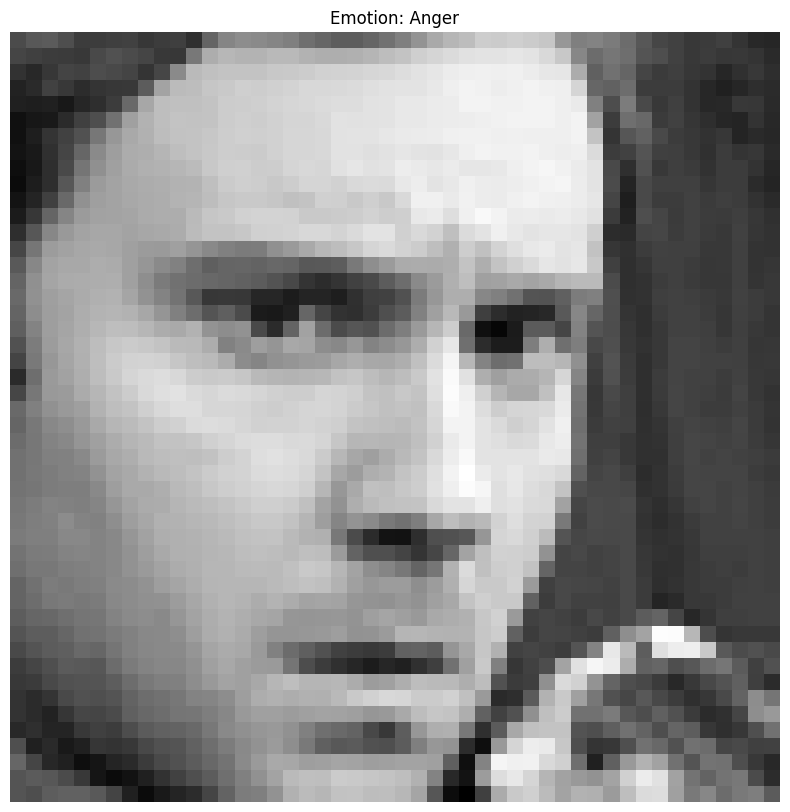

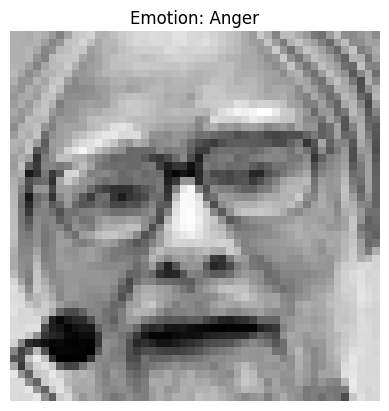

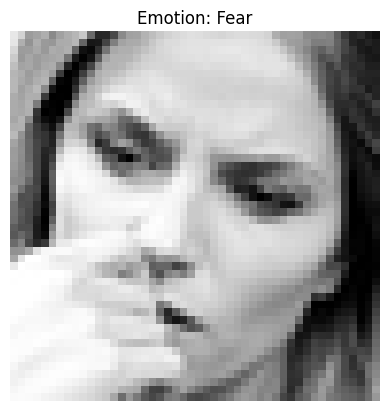

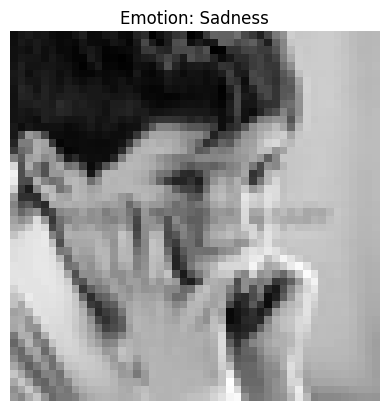

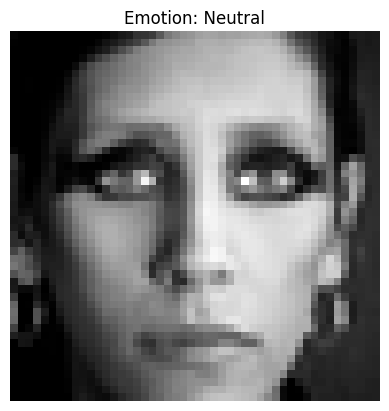

In [9]:
# Emotion mapping
emotion_dict = {
    0: "Anger",
    1: "Disgust",
    2: "Fear",
    3: "Happiness",
    4: "Sadness",
    5: "Surprise",
    6: "Neutral"
}

def plot_example(index):
    row = df.iloc[index]
    pixels = np.array(row['pixels'].split(), dtype=np.uint8).reshape(48, 48)
    label = row['emotion']
    
    plt.imshow(pixels, cmap="gray")
    plt.title(f"Emotion: {emotion_dict[label]}")
    plt.axis("off")
    plt.show()

# Show a few examples
plt.figure(0, figsize=(16,10))
for i in range(5):
    plot_example(i)

In [10]:
df.isna().sum()

emotion    0
pixels     0
Usage      0
dtype: int64

In [11]:
#split data into training, validation and test set
data_train = df[df['Usage']=='Training'].copy()
#data_train = data_train.append(df,ignore_index=True)
data_val   = df[df['Usage']=='PublicTest'].copy() 
data_test  = df[df['Usage']=='PrivateTest'].copy()
print("train shape: {}, \nvalidation shape: {}, \ntest shape: {}".format(data_train.shape, data_val.shape, data_test.shape))

train shape: (28709, 3), 
validation shape: (3589, 3), 
test shape: (3589, 3)


In [12]:
data_test.head()

,emotion,pixels,Usage
32298,0,170 118 101 88 88 75 78 82 66 74 68 59 63 64 6...,PrivateTest
32299,5,7 5 8 6 7 3 2 6 5 4 4 5 7 5 5 5 6 7 7 7 10 10 ...,PrivateTest
32300,6,232 240 241 239 237 235 246 117 24 24 22 13 12...,PrivateTest
32301,4,200 197 149 139 156 89 111 58 62 95 113 117 11...,PrivateTest
32302,2,40 28 33 56 45 33 31 78 152 194 200 186 196 20...,PrivateTest


In [13]:
data_train.emotion.value_counts()

emotion
3    7215
6    4965
4    4830
2    4097
0    3995
5    3171
1     436
Name: count, dtype: int64

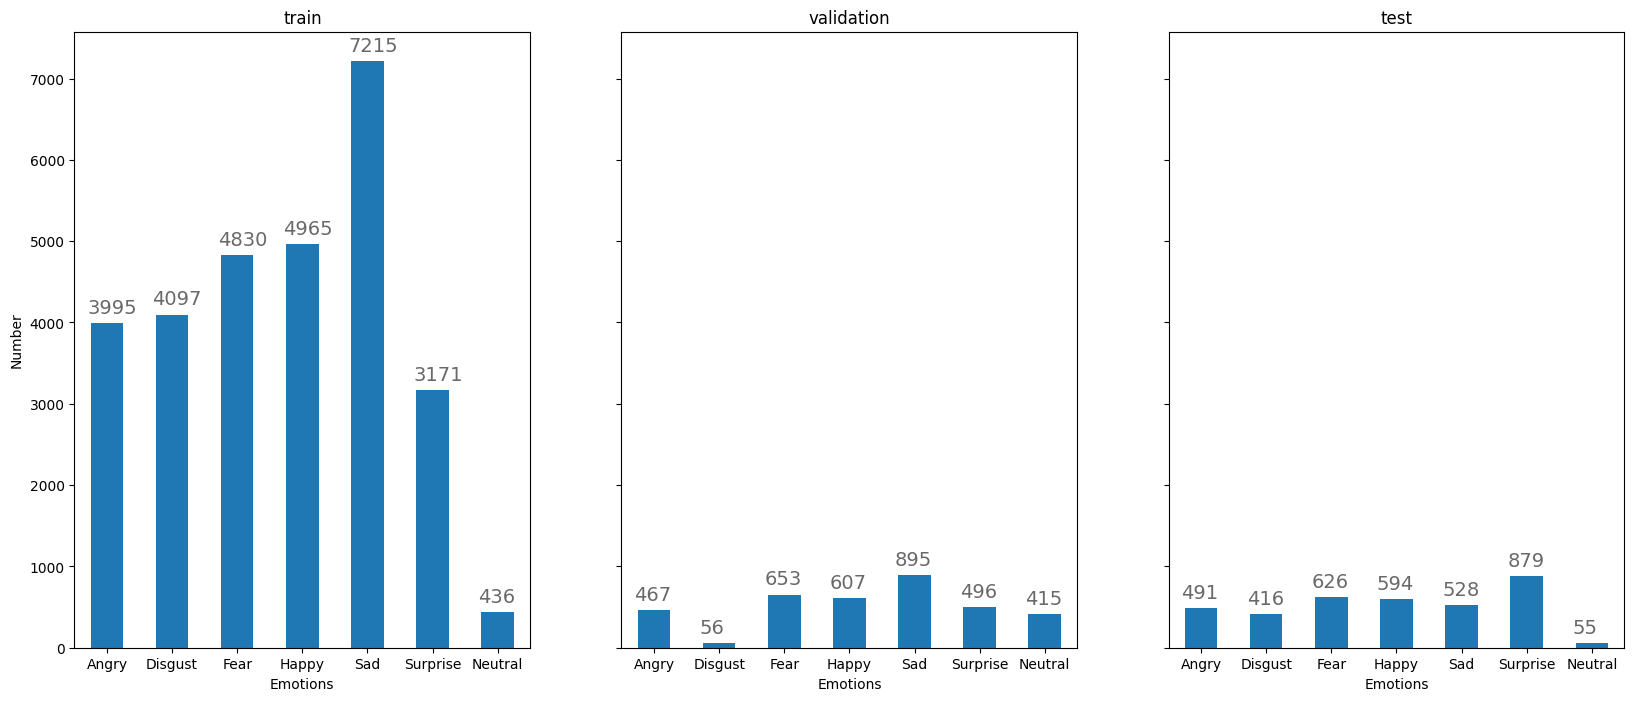

In [14]:
# barplot class distribution of train, val and test
emotion_labels = ['Angry', 'Disgust','Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

fig, axes = plt.subplots(1,3, figsize=(20,8), sharey=True)
setup_axe(axes[0],data_train,'train')
setup_axe(axes[1],data_val,'validation')
setup_axe(axes[2],data_test,'test')
plt.show()

In [15]:
# CRNO stands for Convert, Reshape, Normalize, One-hot encoding
# (i) convert strings to lists of integers
# (ii) reshape and normalise grayscale image with 255.0
# (iii) one-hot encoding label, e.g. class 3 to [0,0,0,1,0,0,0]

def CRNO(df, dataName):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1,width, height,1)/255.0   
    data_Y = to_categorical(df['emotion'], num_classes)  
    print(dataName, "_X shape:", data_X.shape, dataName, "_Y shape:", data_Y.shape)
    #print(data_X) #[[[0.27450982]
    #print(data_Y) #[[1. 0. 0. ... 0. 0. 0.]
    return data_X, data_Y

In [16]:
#initilize parameters
num_classes = 7
width, height = 48, 48
num_epochs = 100
batch_size = 32

In [17]:
# preprocess the data! converts the data into preprocessed images 

# CRNO stands for Convert, Reshape, Normalize, One-hot encoding
# (i) convert strings to lists of integers
# (ii) reshape and normalise grayscale image with 255.0
# (iii) one-hot encoding label, e.g. class 3 to [0,0,0,1,0,0,0]
    
X_train, y_train = CRNO(data_train, "train") #training data
X_val, y_val     = CRNO(data_val, "val") #validation data
X_test, y_test   = CRNO(data_test, "test") #test data

train _X shape: (28709, 48, 48, 1) train _Y shape: (28709, 7)
val _X shape: (3589, 48, 48, 1) val _Y shape: (3589, 7)
test _X shape: (3589, 48, 48, 1) test _Y shape: (3589, 7)


In [18]:
X_train.shape

(28709, 48, 48, 1)

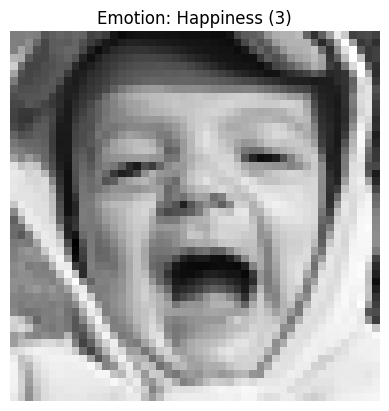

One-hot vector: [0. 0. 0. 1. 0. 0. 0.]


In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Pick a random index
idx = np.random.randint(0, X_train.shape[0])

# Get the image and label
image = X_train[idx].reshape(48, 48)   # remove the channel dimension for plotting
label_vector = y_train[idx]           # one-hot vector
label_index = np.argmax(label_vector) # get class index
label_name = emotion_dict[label_index]  # map index to name

# Plot
plt.imshow(image, cmap="gray")
plt.title(f"Emotion: {label_name} ({label_index})")
plt.axis("off")
plt.show()

print("One-hot vector:", label_vector)

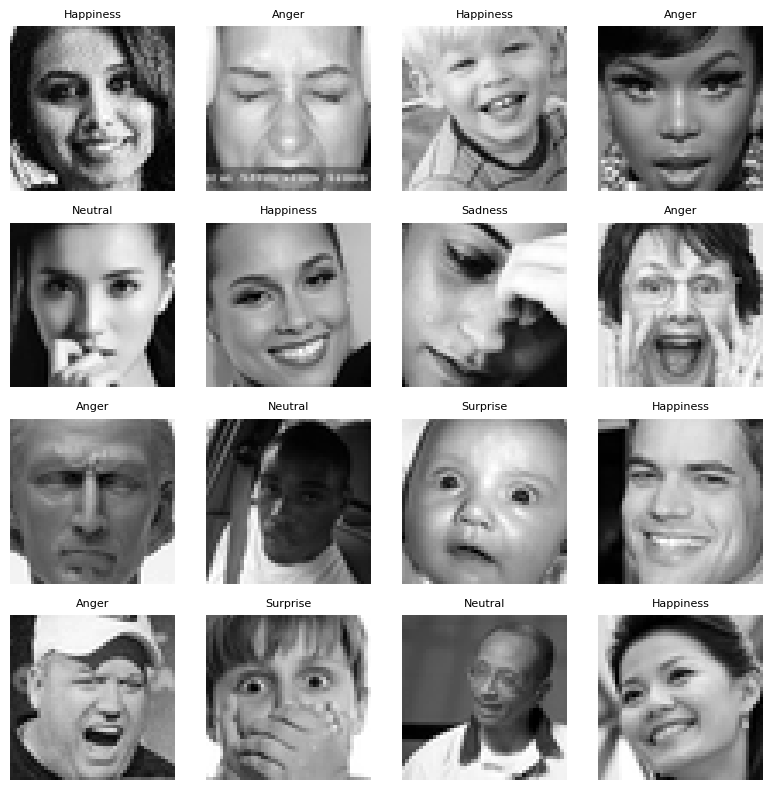

In [20]:

# Pick 16 random indices
indices = np.random.choice(X_train.shape[0], 16, replace=False)

plt.figure(figsize=(8,8))

for i, idx in enumerate(indices):
    image = X_train[idx].reshape(48, 48)   # grayscale → 2D for plotting
    label_vector = y_train[idx]
    label_index = np.argmax(label_vector)
    label_name = emotion_dict[label_index]

    plt.subplot(4,4,i+1)
    plt.imshow(image, cmap="gray")
    plt.title(label_name, fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [21]:
# let's create the baseline model architecture 

from keras.models import Sequential, Model
from keras import Input, models, layers, optimizers, callbacks

base_model = models.Sequential([
    layers.InputLayer(input_shape=(48, 48, 1)),

    layers.Conv2D(32, (3,3), padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Conv2D(32, (3,3), padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3,3), padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Conv2D(64, (3,3), padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3,3), padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Conv2D(128, (3,3), padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(7, activation="softmax"),
])



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
I0000 00:00:1756893544.908225      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1756893544.908907      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [22]:
base_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 32)     │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │       147,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 12, 12, 128)    │             

 Total params: 305,191 (1.16 MB)

 Trainable params: 304,295 (1.16 MB)

 Non-trainable params: 896 (3.50 KB)

In [23]:
base_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [24]:
from keras import callbacks

early_stop = callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=2
)

In [25]:
history = base_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=64,
    epochs=50,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/50


I0000 00:00:1756893553.030654     103 service.cc:148] XLA service 0x7ac61400f190 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756893553.032228     103 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1756893553.032248     103 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1756893553.675235     103 cuda_dnn.cc:529] Loaded cuDNN version 90300


  7/449 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.1577 - loss: 2.3254   

I0000 00:00:1756893560.856177     103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


449/449 ━━━━━━━━━━━━━━━━━━━━ 27s 30ms/step - accuracy: 0.2477 - loss: 1.8476 - val_accuracy: 0.2536 - val_loss: 2.2172 - learning_rate: 0.0010
Epoch 2/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.3879 - loss: 1.5646 - val_accuracy: 0.4012 - val_loss: 1.6408 - learning_rate: 0.0010
Epoch 3/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.4661 - loss: 1.3987 - val_accuracy: 0.3976 - val_loss: 1.7182 - learning_rate: 0.0010
Epoch 4/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.4946 - loss: 1.3257 - val_accuracy: 0.4597 - val_loss: 1.5414 - learning_rate: 0.0010
Epoch 5/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.5165 - loss: 1.2698 - val_accuracy: 0.5208 - val_loss: 1.2421 - learning_rate: 0.0010
Epoch 6/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.5357 - loss: 1.2310 - val_accuracy: 0.4558 - val_loss: 1.4836 - learning_rate: 0.0010
Epoch 7/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.5501 - loss: 1.1986 - val

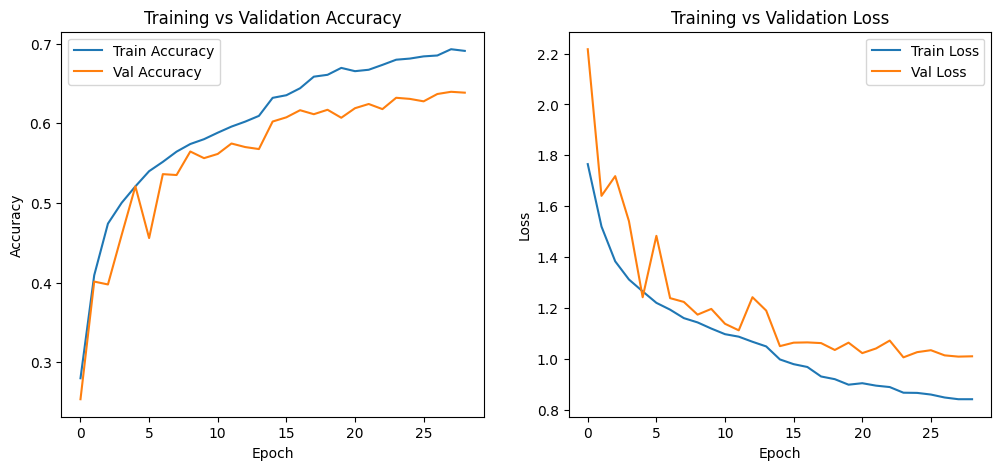

In [26]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Accuracy
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Val Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()

    plt.show()

# Call it after training
plot_history(history)

In [27]:
# let's create a second baseline model architecture 
# lets incorporate class weights 

import numpy as np
from sklearn.utils.class_weight import compute_class_weight

y_indices = np.argmax(y_train, axis=1)  # if Y_train is one-hot
classes = np.arange(7)

weights = compute_class_weight(class_weight="balanced",
                               classes=classes,
                               y=y_indices)
class_weight = {int(c): float(w) for c, w in zip(classes, weights)}
print("Class weights:", class_weight)

Class weights: {0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8491274770777877, 5: 1.293372978330405, 6: 0.8260394187886635}


In [29]:
# this time lets use data augmentation
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

augment = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),   # ~±8°
    layers.RandomZoom(0.10),       # ±10%
    layers.RandomTranslation(0.05, 0.05),  # ≤5% shift
], name="augment")

base_model_2 = models.Sequential([
    layers.InputLayer(input_shape=(48, 48, 1)),
    augment,

    layers.Conv2D(32, (3,3), padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Conv2D(32, (3,3), padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3,3), padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Conv2D(64, (3,3), padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3,3), padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Conv2D(128, (3,3), padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(7, activation="softmax"),
])

base_model_2.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

early_stop = callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=2
)

history_2 = base_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=64,
    epochs=100,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weight
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.6752 - loss: 1.0706 - val_accuracy: 0.6336 - val_loss: 1.0015 - learning_rate: 3.1250e-05
Epoch 2/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.6731 - loss: 1.0057 - val_accuracy: 0.6325 - val_loss: 1.0170 - learning_rate: 3.1250e-05
Epoch 3/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.6681 - loss: 0.9784 - val_accuracy: 0.6303 - val_loss: 1.0163 - learning_rate: 3.1250e-05
Epoch 4/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.6672 - loss: 0.9377 - val_accuracy: 0.6286 - val_loss: 1.0159 - learning_rate: 1.5625e-05
Epoch 5/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.6725 - loss: 0.9401 - val_accuracy: 0.6280 - val_loss: 1.0192 - learning_rate: 1.5625e-05
Epoch 6/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.6614 - loss: 0.9499 - val_accuracy: 0.6303 - val_loss: 1.0219 - learning_rate: 7.8125e-06


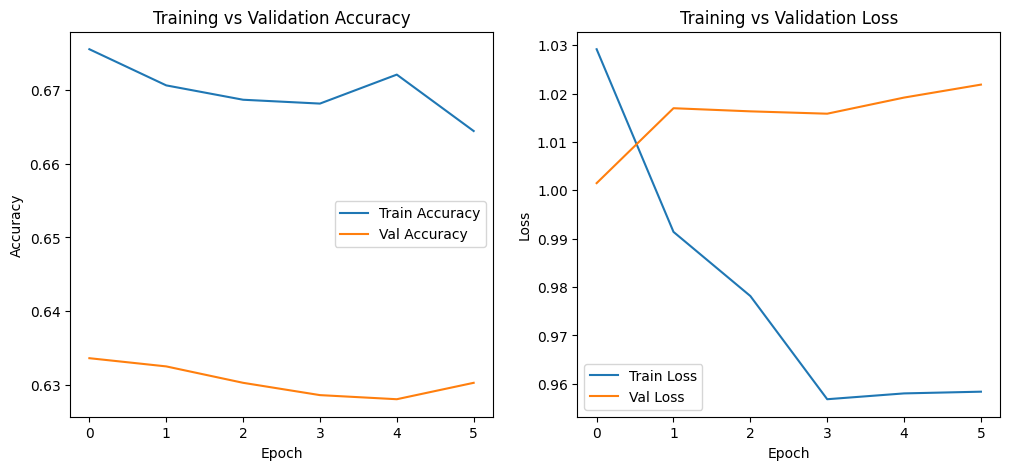

In [30]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Accuracy
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Val Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()

    plt.show()

# Call it after training
plot_history(history_2)

In [31]:
test_loss, test_acc = base_model.evaluate(X_test, y_test, verbose=0)
test_loss2, test_acc2 = base_model_2.evaluate(X_test, y_test, verbose=0)

print(f"Test accuracy on base_model: {test_acc:.4f}")
print(f"Test accuracy on base_model_2: {test_acc2:.4f}")

Test accuracy on base_model: 0.6486
Test accuracy on base_model_2: 0.1605


In [32]:
# ok so the second model collapsed somewhere...
# let's just stick with the first baseline model 
#save it

base_model.save("/kaggle/working/baseline_model.h5")

In [33]:
# now load it to make sure it works 

from tensorflow.keras.models import load_model
loaded_model = load_model("/kaggle/working/baseline_model.h5")

test_loss, test_acc = loaded_model.evaluate(X_test, y_test, verbose=0)
print("Test accuracy:", test_acc)

Test accuracy: 0.6486486196517944
